<center> <h1>Detection of objects on Piping & Instrumentation Diagrams</h1> </center>

## Task description
A Piping and Instrumentation Diagram (P&ID or PID) is a detailed diagram in the process industry which shows process equipment together with the instrumentation and control devices. The goal of the following research is detection certain objects types using Comuter Vision approaches.

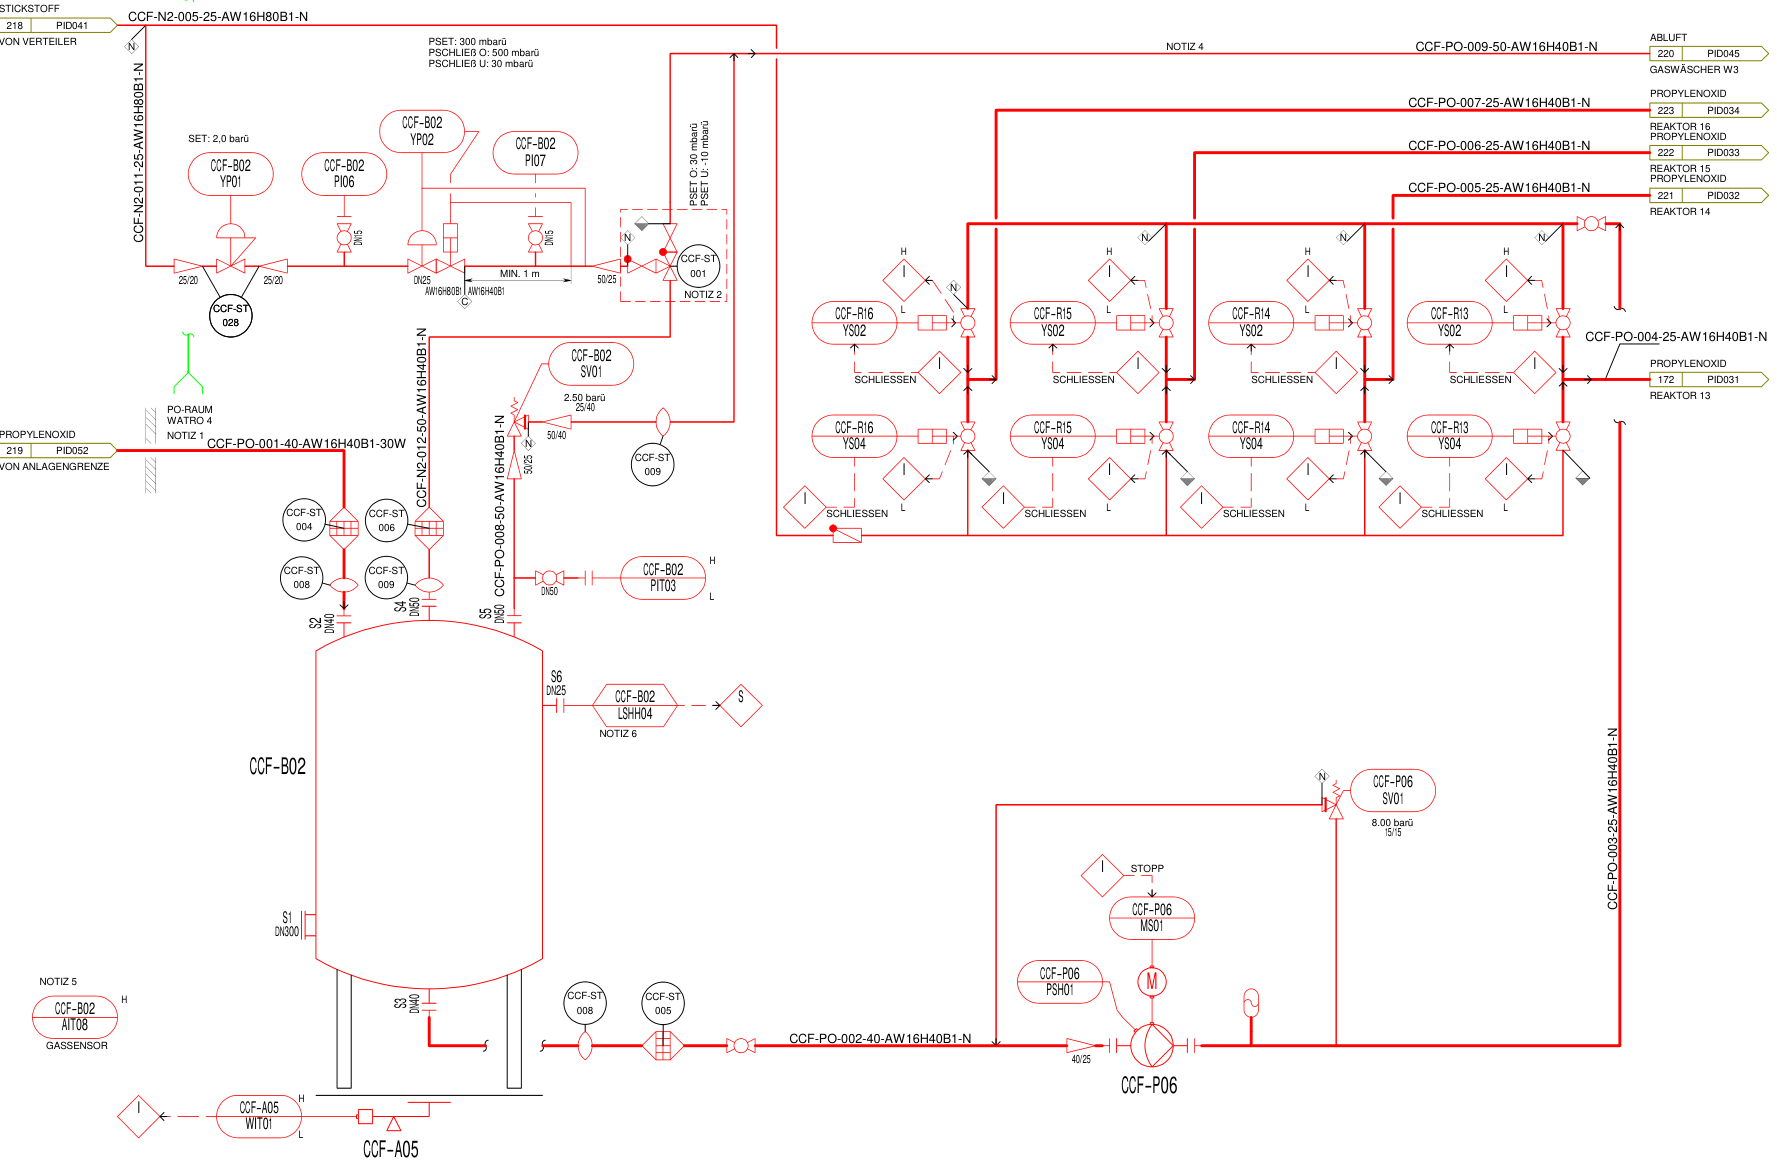

We are interesting in the following object classes:

 - Equipment
 - Valve
 - Instrument Valve
 - Label Equipment
 - Label Valve
 - Label Instrument
 - Label Pipeline

## 1. Research for available solutions 

Only one research of the similar problem was founded:

[Handwritten Electrical Schema Recognition](https://azizamari.tn/projects/circuit.html)

The authors use neural network of the YOLO architecture to recognition of the components on the handwriten schemas:

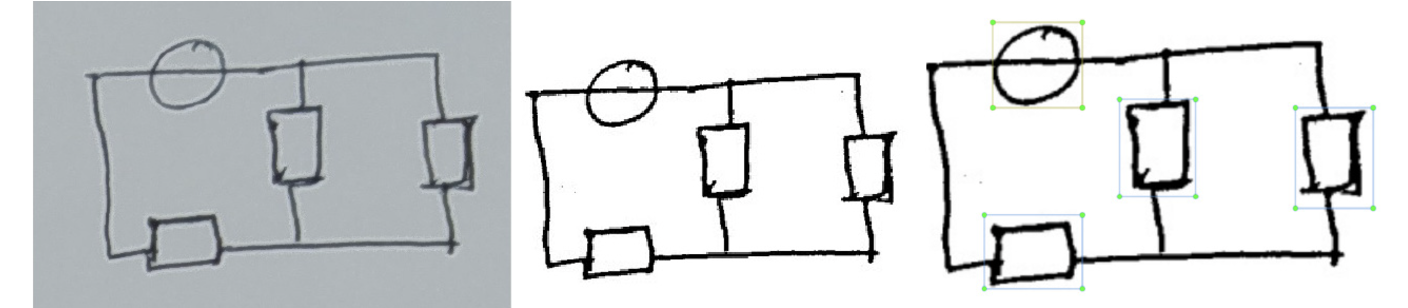

## 2. Preparing environment

In [79]:
!yolo check

Ultralytics 8.3.51 🚀 Python-3.11.4 torch-2.5.1 CPU (Apple M1 Pro)
Setup complete ✅ (10 CPUs, 16.0 GB RAM, 191.0/926.4 GB disk)

OS                  macOS-12.3-arm64-arm-64bit
Environment         Darwin
Python              3.11.4
Install             pip
RAM                 16.00 GB
Disk                191.0/926.4 GB
CPU                 Apple M1 Pro
CPU count           10
GPU                 None
GPU count           None
CUDA                None

numpy               ✅ 1.26.4>=1.23.0
numpy               ✅ 1.26.4<2.0.0; sys_platform == "darwin"
matplotlib          ✅ 3.9.2>=3.3.0
opencv-python       ✅ 4.10.0.84>=4.6.0
pillow              ✅ 11.0.0>=7.1.2
pyyaml              ✅ 6.0.2>=5.3.1
requests            ✅ 2.32.3>=2.23.0
scipy               ✅ 1.14.1>=1.4.1
torch               ✅ 2.5.1>=1.8.0
torch               ✅ 2.5.1!=2.4.0,>=1.8.0; sys_platform == "win32"
torchvision         ✅ 0.20.1>=0.9.0
tqdm                ✅ 4.67.1>=4.64.0
psutil              ✅ 6.1.0
py-cpuinfo          ✅ 9.0.0
pan

In [80]:
import ast
import cv2
import numpy as np
import os
import pandas as pd
import random
import torch
import json
from pycocotools.coco import COCO
import supervision as sv


from collections import Counter
from tqdm.notebook import tqdm
from ultralytics import YOLO

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

## 3. Dataset inspections


Image shape:       (1684, 2384, 3)


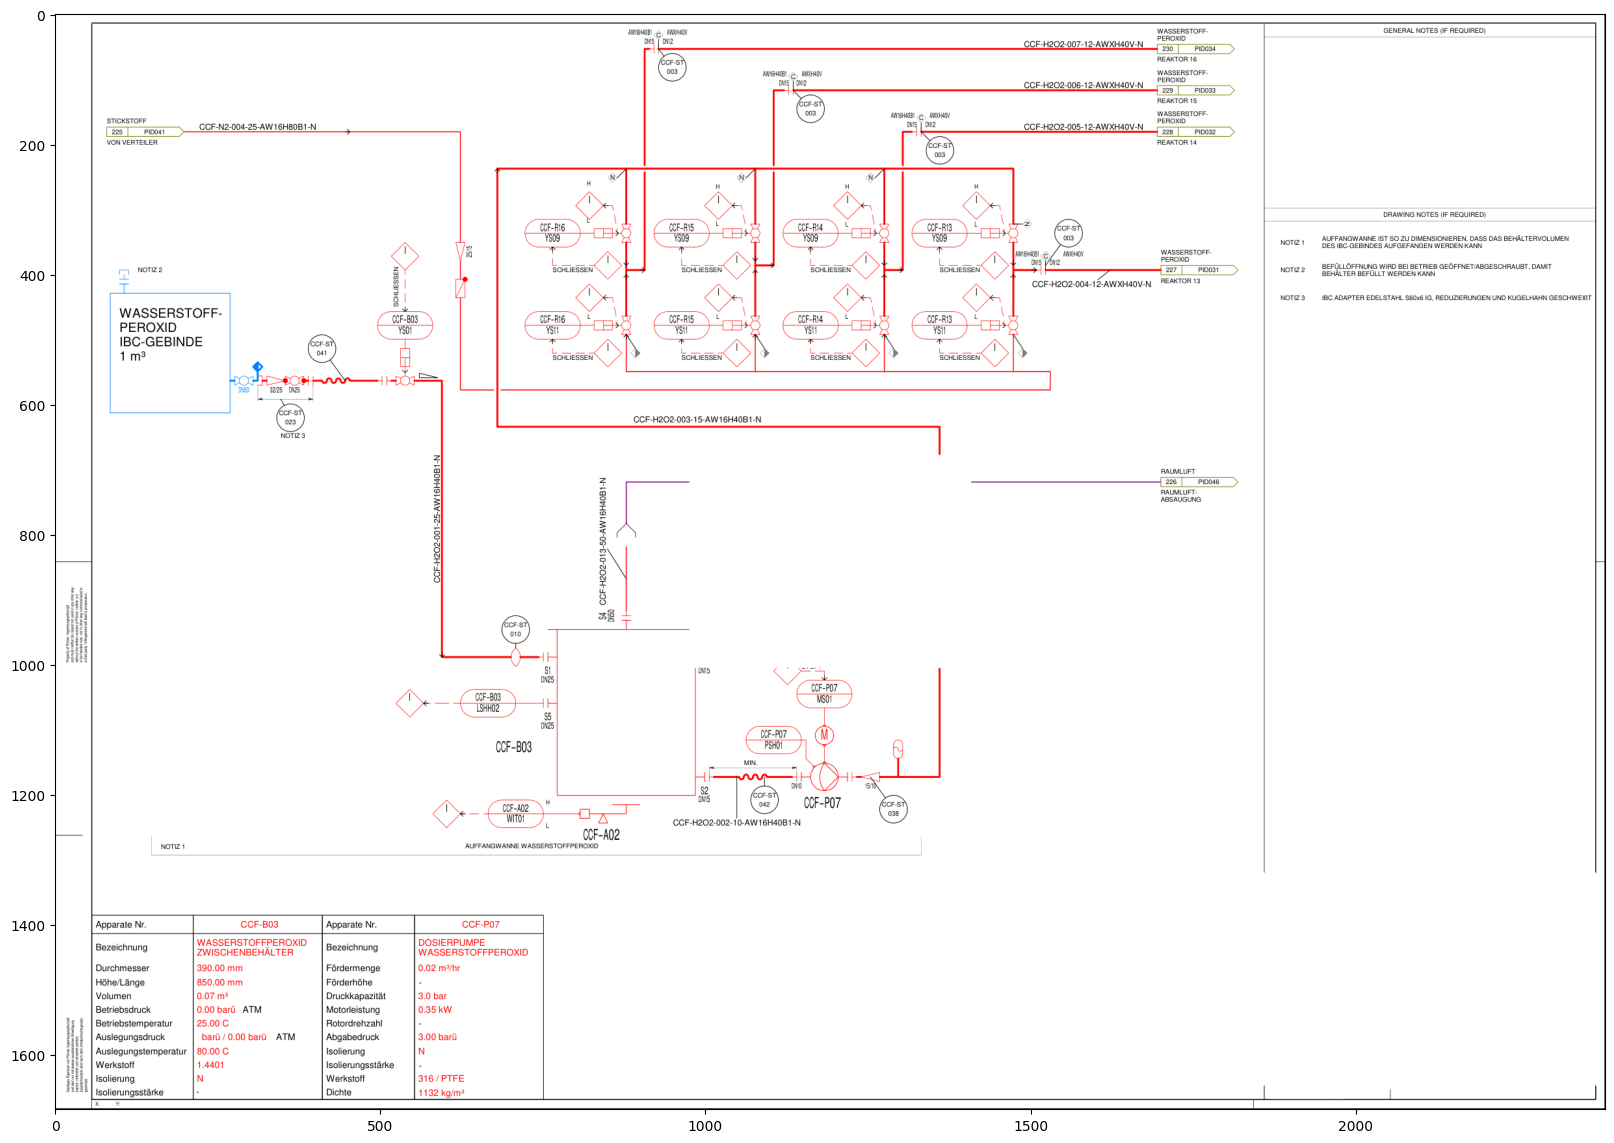

In [81]:
def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

def imread_gray(filename):
    image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    return np.stack((image,) * 3, axis=-1)

data_folder = '/Users/windsurfer_ua/dev/Computer-Vision-Course/PID objects detection/dataset'
imfiles = os.listdir(os.path.join(data_folder, 'images'))
imfiles = [os.path.join(data_folder, 'images', f) for f in imfiles if os.path.splitext(f)[-1] == '.png']

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)

print('Image shape:      ', image.shape)

- The image size 1684x2384. Resizing to 640px will loose a lot of info for small parts. We have to train network on slices.
- Images have colors - this is irrelevant for our task. We will train network on converted to Grayscale or even Binary images ...

## 3. Dataset labeling

For dataset labeling we used Label - Studio -  open source software.

For testing purpose of the training pipeline we lableв only limited set of drawings.

## 4. Dataset loading

In [82]:
# Label-studio can do export direct in YOLO format. But we need to slile images and labels into 640px slices befo train.
# So we decided to use COCO-format export 

def load_coco_annotations(json_file):
    """
    Load COCO annotations from a JSON file into a Pandas DataFrame.

    Args:
        json_file (str): Path to the COCO annotations JSON file.

    Returns:
        pd.DataFrame: DataFrame containing the annotation data.
    """
    # Read the JSON file
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Extract relevant data from the COCO format
    images = {image['id']: image for image in data.get('images', [])}
    annotations = data.get('annotations', [])

    # Create a list of records combining image and annotation data
    records = []
    for annotation in annotations:
        image_info = images.get(annotation['image_id'], {})
        record = {
            'image_id': annotation.get('image_id'),
            'file_name': image_info.get('file_name')[7:],
            'width': image_info.get('width'),
            'height': image_info.get('height'),
            'category_id': annotation.get('category_id'),
            'x': int(annotation.get('bbox')[0]),
            'y': int(annotation.get('bbox')[1]),
            'w': int(annotation.get('bbox')[2]),
            'h': int(annotation.get('bbox')[3]),
            'bbox': [int(annotation.get('bbox')[0]), int(annotation.get('bbox')[1]),
                                                        int(annotation.get('bbox')[0]) + int(annotation.get('bbox')[2]),
                                                        int(annotation.get('bbox')[1]) + int(annotation.get('bbox')[3])]                                  
        }
        records.append(record)

    # Convert the records into a DataFrame
    df = pd.DataFrame(records)
    
    return df


In [83]:
json_file = os.path.join(data_folder,"result.json")  
annotations = load_coco_annotations(json_file)
print(annotations.head())

   image_id                              file_name  width  height  \
0         0  2e533252-D12920F_PIDALL_H_Part1_6.png   2384    1684   
1         0  2e533252-D12920F_PIDALL_H_Part1_6.png   2384    1684   
2         0  2e533252-D12920F_PIDALL_H_Part1_6.png   2384    1684   
3         0  2e533252-D12920F_PIDALL_H_Part1_6.png   2384    1684   
4         0  2e533252-D12920F_PIDALL_H_Part1_6.png   2384    1684   

   category_id     x     y    w    h                      bbox  
0            0   499   729  290  330     [499, 729, 789, 1059]  
1            3   589   883  101   31      [589, 883, 690, 914]  
2            5   869   743  202   29     [869, 743, 1071, 772]  
3            5  1139  1008  210   20  [1139, 1008, 1349, 1028]  
4            5   713  1067  213   18    [713, 1067, 926, 1085]  


In [84]:
# Getting info about classification classes (categories)
coco = COCO(json_file)
coco.cats

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{0: {'id': 0, 'name': 'Equipment'},
 1: {'id': 1, 'name': 'Instrument'},
 2: {'id': 2, 'name': 'Instrument Valve'},
 3: {'id': 3, 'name': 'Label Equipment'},
 4: {'id': 4, 'name': 'Label Instrument'},
 5: {'id': 5, 'name': 'Label Pipeline'},
 6: {'id': 6, 'name': 'Label Valve'},
 7: {'id': 7, 'name': 'Valve'}}

In [85]:
Counter(annotations['category_id'])

Counter({4: 112, 7: 69, 2: 63, 5: 44, 0: 43, 3: 13, 6: 10, 1: 2})

In [86]:
### lets visualise some image with annotations

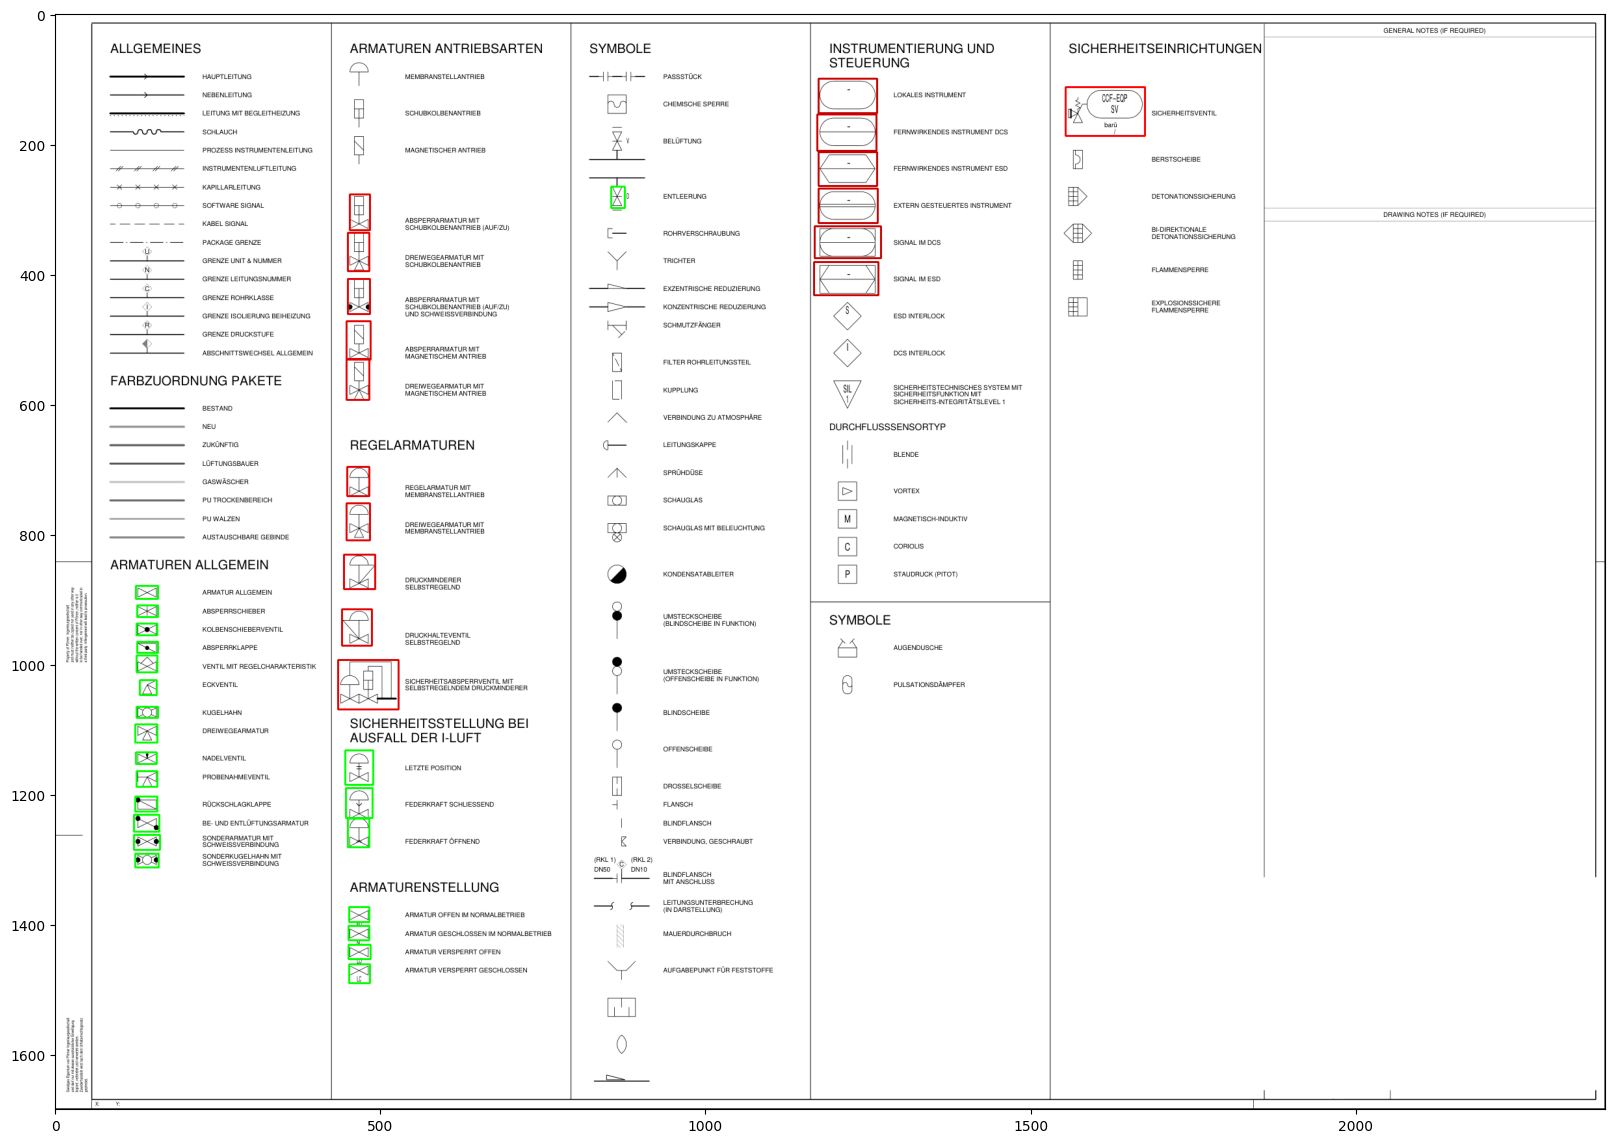

In [87]:
label_to_color={0: (0, 0, 255),
                1: (255,0,0),
                2: (230,0,0),
                3: (0,0,200),
                4: (200,0,0),
                5: (0,200,0),
                6: (0,200,0),
                7: (0,255,0)}

sample = random.choice(imfiles)
image = imread_gray(sample)

labels = annotations[annotations.file_name == os.path.basename(sample)]
for _,label in labels.iterrows():
    cv2.rectangle(image,label.bbox[:2],label.bbox[2:],label_to_color[label.category_id],thickness=2)

plt.imshow(image)

### Data Format Conversion

We will split each image into 640x640 crops. 
Therefore, we create a separate dataset with image crops.
We will need to adjust the bounding boxes as well.

In [88]:
def recompute_box_coors(bbox, x_origin, y_origin, width, height, threshold):
    """Recompute box coordinates to new origin
    
    Args:
        bbox (np.ndarray): Bounding box coordinates in form (x_top, y_top,x_bottom,y_bottom).
        x_origin (int): X coordinate of the origin of the new coordinate system.
        y_origin (int): Y coordinate of the origin of the new coordinate system.
        width (int): Width of the new coordinate system. Recomputed box coordinates
            that would fall beyond will be truncated.
        threshold (float): Rejection ratio of bounding box after truncation. Recomputed
            boxes that are heavily truncated will be discarded.
            
    Returns:
        (tuple): Recomputed bounding boxes in YOLOv8 data format.
        
    """
    # Recompute bounds coordinates to new reference
    x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3]
    x_min, y_min, x_max, y_max = x_min - x_origin, y_min - y_origin, x_max - x_origin, y_max - y_origin

    # Return None if the box does not lie within image crop
    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None
    
    # Truncate box x coordinates if necessary
    x_max_trunc = min(x_max, width)
    x_min_trunc = max(x_min, 0)
    # Skip if truncate too much
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < threshold:
        return None

    # Repeat for y coordinates
    y_max_trunc = min(y_max, width) 
    y_min_trunc = max(y_min, 0) 
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < threshold:
        return None
        
    # Convert to YOLOv8 format
    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height
    
    return (0, x_center, y_center, x_extend, y_extend)

#### Data Splitting

Split data into train and validation set and prepare the folders for storing the images and annotations.

In [89]:
fnames = list(annotations['file_name'].unique())
np.random.shuffle(fnames)
train_split = fnames[0:int(len(fnames)*0.8)]

#print('Num samples', len(fnames))
#print('Train split', len(train_split))
#print('Val split  ', len(fnames) - len(train_split))

In [90]:
folder_crops = {'train': os.path.join(data_folder,'train','images'),
                'val':  os.path.join(data_folder,'val','images')}

folder_labels = {'train': os.path.join(data_folder,'train','labels'),
                'val':  os.path.join(data_folder,'val','labels')}

for folders in [folder_crops, folder_labels]:
    for _, folder in folders.items():
        if not os.path.isdir(folder):
            os.makedirs(folder)

Create image crops and adjust the corresponding labels. The labels will be stored in seperate txt files (one for each image), as required by YOLOv8 format.

In [91]:
crop_size = 640
crop_overlap = 64
trunc_th = 0.8
step = crop_size - crop_overlap


for imfile in (imfiles):    
    image = imread(imfile)
    folder = 'train' if os.path.basename(imfile) in train_split else 'val'

    # Get annotations for image
    labels = annotations[annotations.file_name == os.path.basename(imfile)]
    img_id = os.path.splitext(os.path.basename(imfile))[0]    

    rows, cols,_ = image.shape
    
    # Extract crops
    for x_start in tqdm(np.arange(0, cols - crop_size, step)):
        for y_start in np.arange(0, rows - crop_size, step):

            x_end = x_start + crop_size
            y_end = y_start + crop_size
            
            filename_crop = os.path.join(folder_crops[folder],
                                         img_id + '_' + str(x_start) + '_' + str(y_start) + '.jpg')
            filename_label = os.path.join(folder_labels[folder],
                                          img_id + '_' + str(x_start) + '_' + str(y_start) + '.txt')
                                        
            crop = image[y_start:y_end, x_start:x_end]
            assert crop.shape == (crop_size, crop_size,3)                
            cv2.imwrite(filename_crop, crop)

            boxes = [recompute_box_coors(box, x_start, y_start, crop_size, crop_size, trunc_th)
                     for box in labels['bbox']]
            boxes = [box for box in boxes if box is not None]            

            # save labels
            with open(filename_label, 'w+') as f:
                for box in boxes:
                    f.write(' '.join(str(x) for x in box) + '\n')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Let us visualize the crops and the corresponding labels to check that the cropping has worked properly.

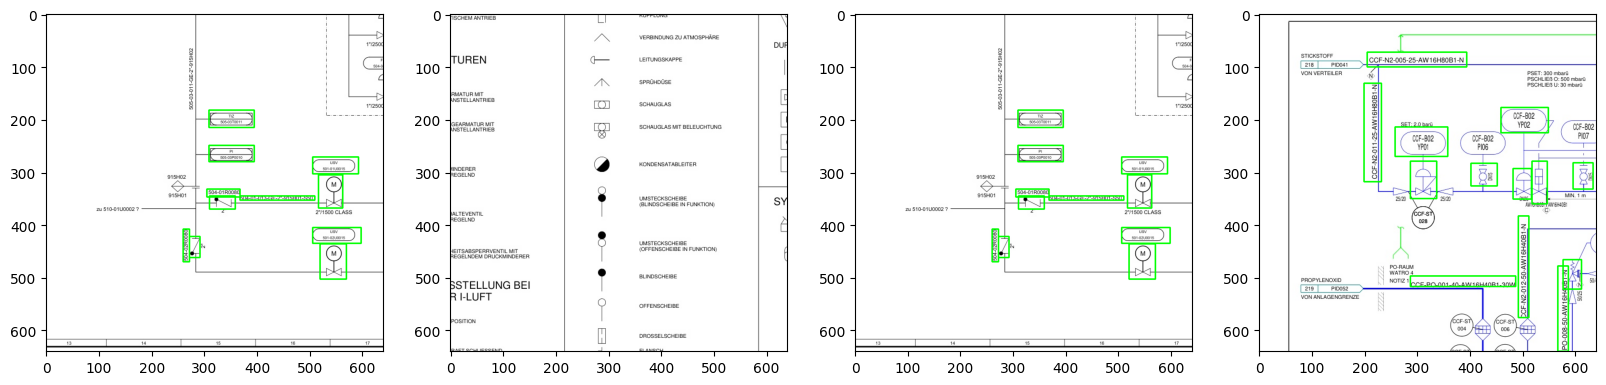

In [93]:
for idx, sample in enumerate(np.random.choice(os.listdir(folder_crops['train']), 4)):
    
    # Load image and corresponding labels
    image = imread(os.path.join(folder_crops['train'], sample))
    with open(os.path.join(folder_labels['train'], sample.replace('.jpg', '.txt')), 'r') as f:
        labels = f.readlines()

    for box in labels:
        box = np.array([d for d in box.split(' ')], dtype=np.float32)
        
        # Undo coordinate normalization
        x_center = box[1] * crop_size
        y_center = box[2] * crop_size

        width = box[3] * crop_size
        height = box[4] * crop_size

        # Convert from YOLOv8 format to OpenCV rectangle format
        x_start, y_start = int(x_center - width/2), int(y_center - height/2)
        x_end, y_end = int(x_center + width/2), int(y_center + height/2)

        cv2.rectangle(image, (x_start, y_start), (x_end, y_end), color=(0, 255, 0), thickness=2)

    plt.subplot(1,4,idx+1), plt.imshow(image)

### YOLOv8

Let's now load the detection model. There are different model [sizes](https://github.com/ultralytics/ultralytics) pretrained on [COCO](https://docs.ultralytics.com/datasets/detect/coco/) that you can chose from. We will use the small model here.

In [118]:
model = YOLO("yolov8s.pt")
model.info()

100%|██████████████████████████████████████| 21.5M/21.5M [00:20<00:00, 1.11MB/s]


YOLOv8s summary: 225 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)


0: 160x640 (no detections), 67.8ms
Speed: 3.0ms preprocess, 67.8ms inference, 5.3ms postprocess per image at shape (1, 3, 160, 640)

0: 160x640 1 tennis racket, 61.5ms
Speed: 1.1ms preprocess, 61.5ms inference, 3.9ms postprocess per image at shape (1, 3, 160, 640)

0: 160x640 (no detections), 53.8ms
Speed: 0.9ms preprocess, 53.8ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)

0: 160x640 (no detections), 63.7ms
Speed: 1.5ms preprocess, 63.7ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 640)


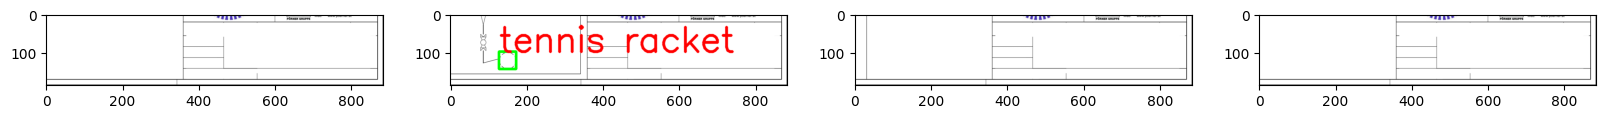

In [122]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    image = image[1500:, 1500:, :]

    result = model.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 255, 0), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 6, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)

### Train YOLOv8 on Custom Dataset

In [125]:
config = """
# train and val datasets (image directory or *.txt file with image paths)
train: /Users/windsurfer_ua/dev/Computer-Vision-Course/lesson_18/train
val: /Users/windsurfer_ua/dev/Computer-Vision-Course/lesson_18/val

# number of classes
nc: 1

# class names
names: ['Components']
"""

with open("data.yaml", "w") as f:
    f.write(config)

Training settings:
    https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters

In [126]:
root = "/Users/windsurfer_ua/dev/Computer-Vision-Course/lesson_18/"
!yolo task=detect mode=train model=yolov8s.pt data={root}/data.yaml epochs=10 imgsz=640 mosaic=0.0 flipud=0.0 fliplr=0 scale=0.0

Ultralytics 8.3.51 🚀 Python-3.11.4 torch-2.5.1 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/windsurfer_ua/dev/Computer-Vision-Course/lesson_18//data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

In [2]:
retrained = YOLO('/Users/windsurfer_ua/dev/Computer-Vision-Course/lesson_18/runs/detect/train/weights/best.pt')


0: 640x640 6 Componentss, 273.9ms
Speed: 1.6ms preprocess, 273.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Componentss, 125.8ms
Speed: 1.4ms preprocess, 125.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Componentss, 135.2ms
Speed: 1.8ms preprocess, 135.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 153.5ms
Speed: 1.6ms preprocess, 153.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


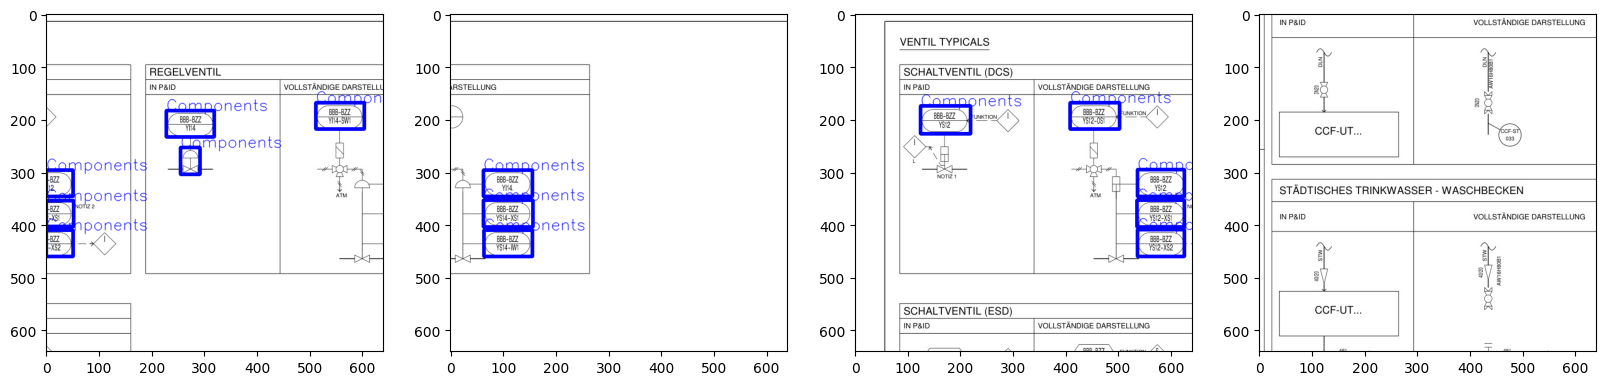

In [3]:
tst_data_folder = os.path.join(data_folder,'val','images')
tst_files = os.listdir(tst_data_folder)
tst_files = [os.path.join(tst_data_folder,f) for f in tst_files if os.path.splitext(f)[-1] == '.jpg']


for idx, sample in enumerate(np.random.choice(tst_files, 4)):
    image = imread_gray(sample)


    result = retrained.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 0, 255), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)

In [4]:
def callback(image_slice: np.ndarray) -> sv.Detections:
    result = retrained(image_slice)[0]
    return sv.Detections.from_ultralytics(result)

slicer = sv.InferenceSlicer(callback = callback)

#detections = slicer(image)

SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.



0: 640x640 (no detections), 145.2ms
Speed: 2.4ms preprocess, 145.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Components, 153.7ms
Speed: 3.9ms preprocess, 153.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Componentss, 170.7ms
Speed: 2.8ms preprocess, 170.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Components, 136.4ms
Speed: 2.4ms preprocess, 136.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Components, 160.8ms
Speed: 2.5ms preprocess, 160.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Components, 161.8ms
Speed: 3.2ms preprocess, 161.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Components, 165.0ms
Speed: 3.0ms preprocess, 165.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 148.6ms
Speed: 2.4ms preprocess, 148.6ms in

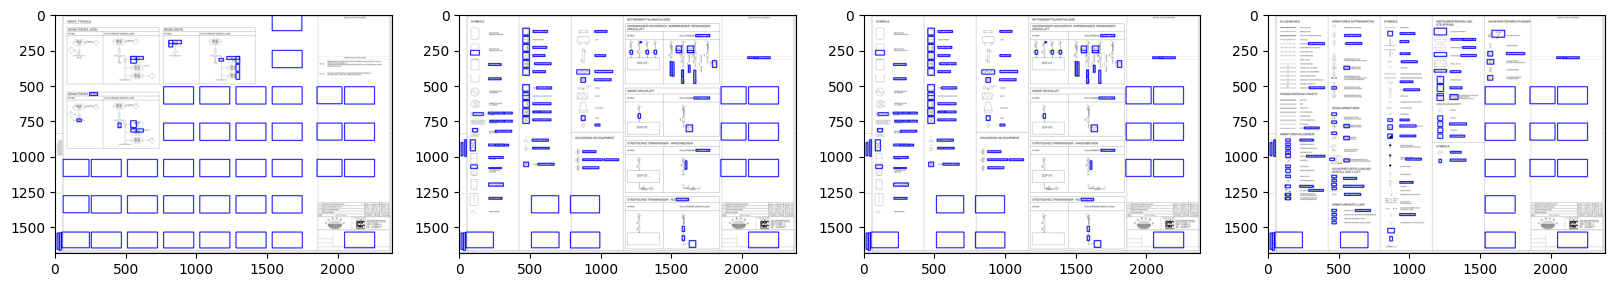

In [9]:
tst_data_folder = os.path.join(data_filder,images)
tst_files = os.listdir(tst_data_folder)
tst_files = [os.path.join(tst_data_folder,f) for f in tst_files if os.path.splitext(f)[-1] == '.png']


for idx, sample in enumerate(np.random.choice(tst_files, 2)):
    image = imread_gray(sample)


    #result = retrained.predict(image, conf=0.2)[0]
    result = slicer(image)
    boxes = result.xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 0, 255), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        #image = cv2.putText(image, result.data.clas_name[result.boxes.cls[box_idx].item()], (box[0], box[1]),
        #                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)

In [6]:
result

Detections(xyxy=array([[     19.924,      282.49,      38.166,      313.71],
       [      47.97,      328.37,      95.174,       376.8],
       [     362.19,      301.65,      474.06,      314.47],
       [     312.29,      301.15,      434.38,      313.18],
       [        256,         512,      469.67,      631.94],
       [        512,         512,      597.12,      560.91]]), mask=None, confidence=array([    0.25168,     0.55411,     0.49394,     0.43441,     0.86329,     0.90963], dtype=float32), class_id=array([0, 0, 0, 0, 0, 0]), tracker_id=None, data={'class_name': array(['Components', 'Components', 'Components', 'Components', 'Components', 'Components'], dtype='<U10')}, metadata={})

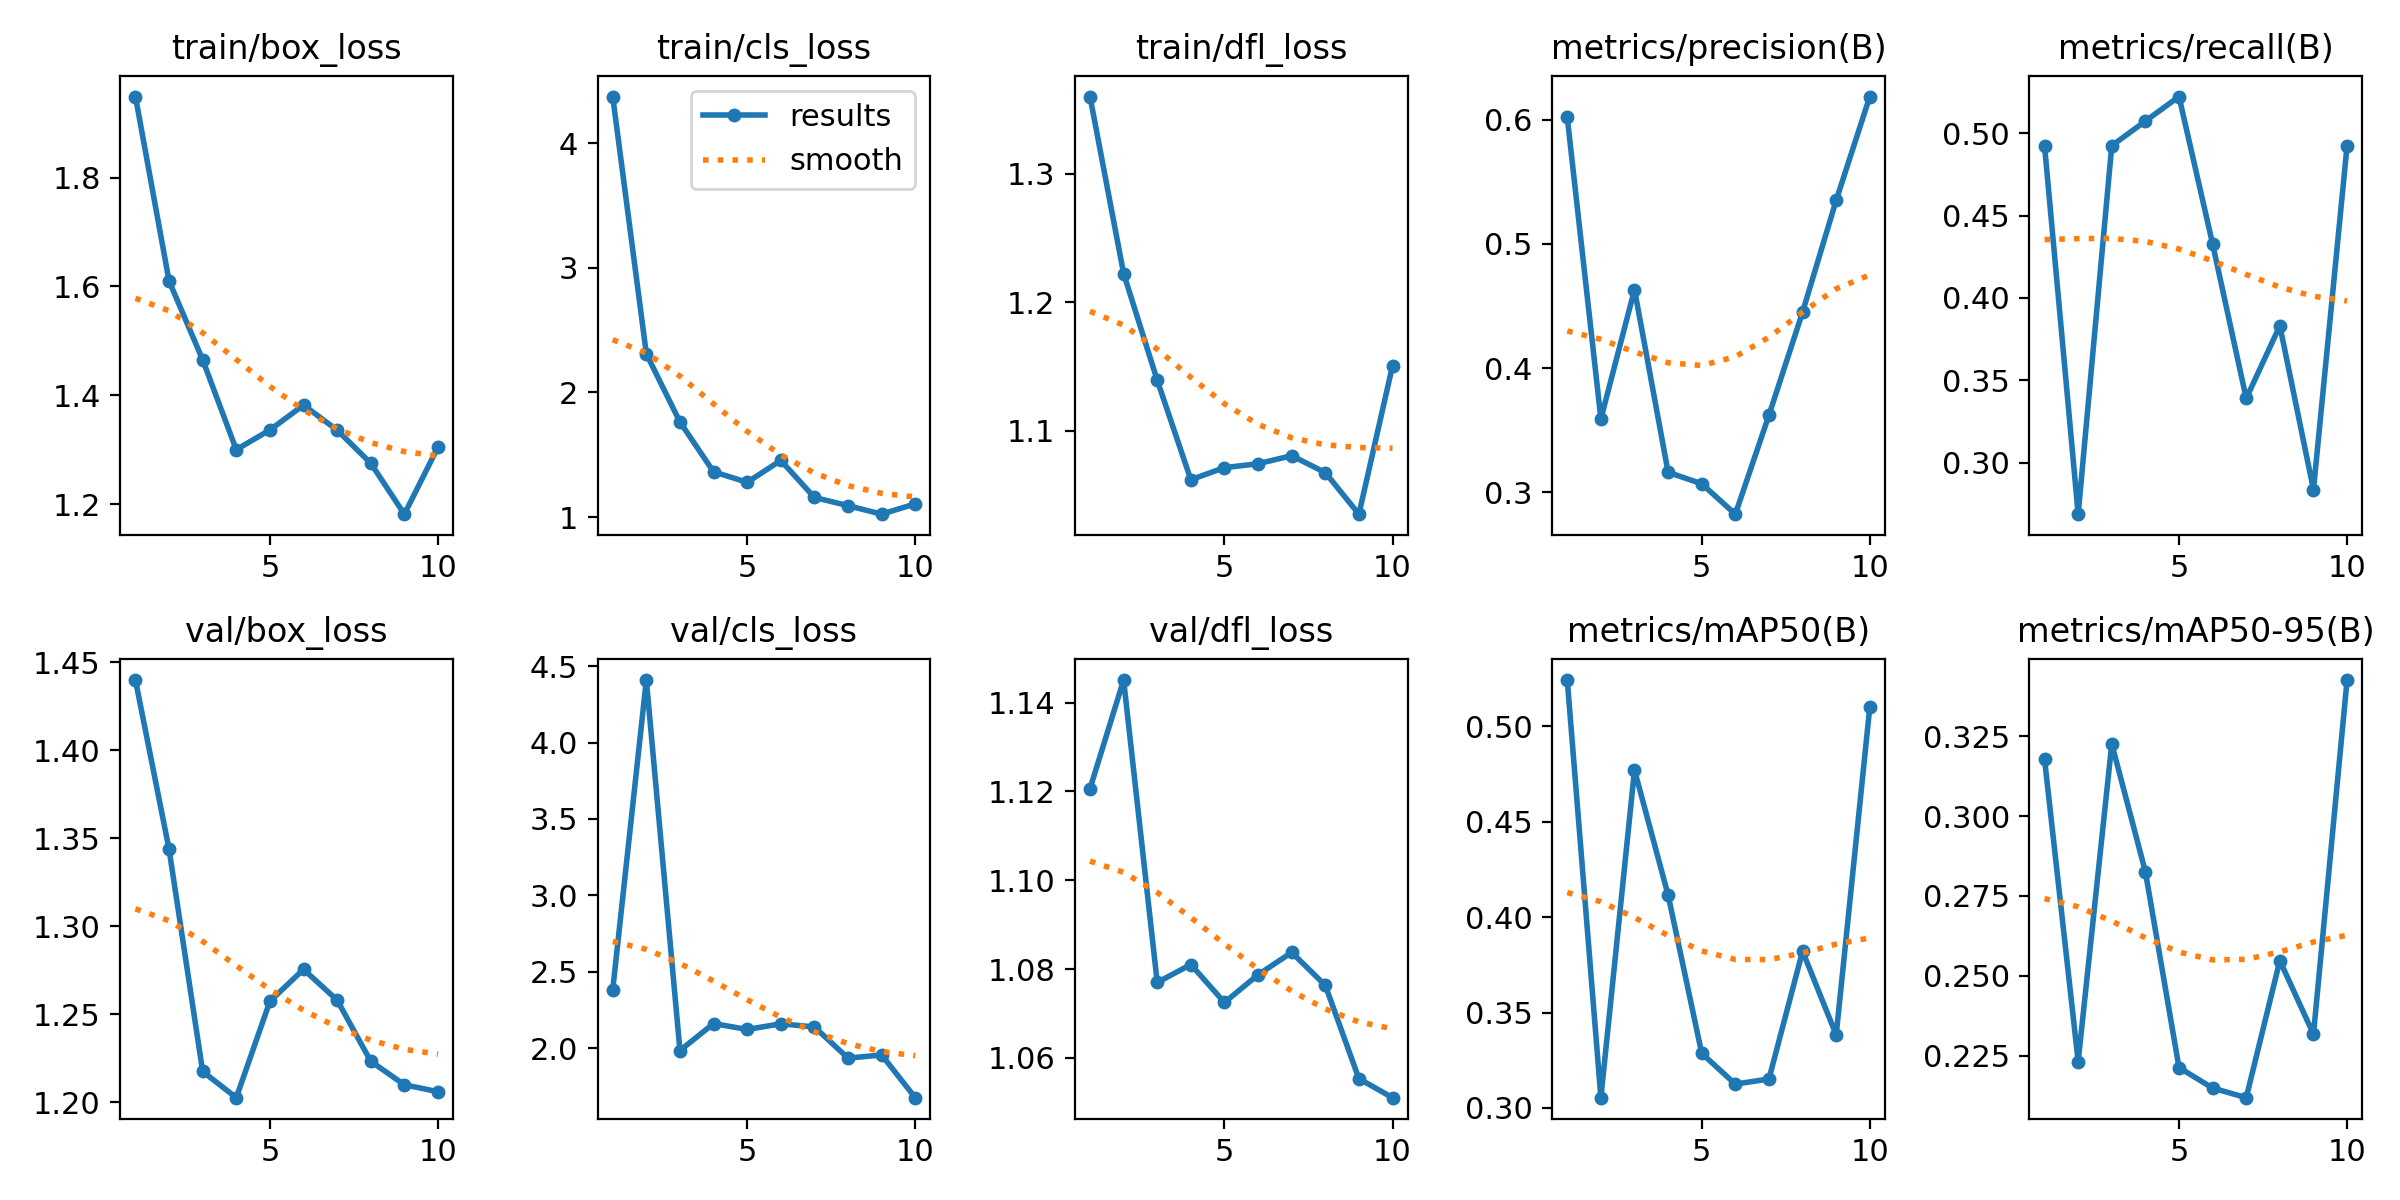
